<a href="https://colab.research.google.com/github/megezer0/AppCV_2025/blob/main/Copy_of_Fine_Tuning_YoloV8nano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Stop Sign Detection with YOLOv8 on Google Colab

This notebook guides you through preparing your dataset, fine-tuning a YOLOv8 nano model, and exporting it for deployment on a Raspberry Pi.

# 1. Setup Google Colab Environment

First, we need to install the necessary libraries and set up the environment in Colab.

In [1]:
# @title Install Ultralytics YOLOv8
!pip install ultralytics -q
print("Ultralytics YOLOv8 installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.9 MB/s eta 0:00:00
Ultralytics YOLOv8 installed successfully!


In [2]:
# @title Check GPU Availability (Optional but Recommended)
import torch

if torch.cuda.is_available():
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Training will run on CPU, which will be slower.")

GPU is available. Using: Tesla T4


# 2. Prepare Your Dataset Directories

We will create the necessary directory structure directly in Colab. This keeps your image files and annotation files organized.

In [3]:
# @title Create Dataset Directories
import os

dataset_base_dir = '/content/stop_sign_dataset'
images_dir = os.path.join(dataset_base_dir, 'images')
annotations_dir = os.path.join(dataset_base_dir, 'annotations') # To store the original XML

os.makedirs(images_dir, exist_ok=True)
os.makedirs(annotations_dir, exist_ok=True)

# Directory for YOLO-formatted labels
yolo_labels_dir = os.path.join(dataset_base_dir, 'labels')
os.makedirs(yolo_labels_dir, exist_ok=True)

print(f"Created dataset directories:")
print(f"- {images_dir}")
print(f"- {annotations_dir}")
print(f"- {yolo_labels_dir} (for processed YOLO labels)")

Created dataset directories:
- /content/stop_sign_dataset/images
- /content/stop_sign_dataset/annotations
- /content/stop_sign_dataset/labels (for processed YOLO labels)


# 3. Upload Your Data

Now, you'll upload your images and the `annotations.xml` file.

**Instructions for Students:**

1.  **Upload Images:** Drag and drop all your `img_XXX.jpg` files (from your `finetuned_images/captured_images` folder) into the `/content/stop_sign_dataset/images` directory in the Colab file browser (left sidebar -> folder icon).
2.  **Upload `annotations.xml`:** Drag and drop your `annotations.xml` file into the `/content/stop_sign_dataset/annotations` directory in the Colab file browser.

*You will perform these uploads manually using the Colab UI.*

In [4]:
# @title Verify Uploaded Files (Run after manual upload)
import os

print("Images uploaded:")
!ls -lh /content/stop_sign_dataset/images/ | head -n 10 # List first 10 image files

print("\nAnnotations XML uploaded:")
!ls -lh /content/stop_sign_dataset/annotations/

Images uploaded:
total 4.2M
-rw-r--r-- 1 root root 54K Jun 11 15:02 img_000.jpg
-rw-r--r-- 1 root root 47K Jun 11 15:02 img_001.jpg
-rw-r--r-- 1 root root 46K Jun 11 15:02 img_002.jpg
-rw-r--r-- 1 root root 42K Jun 11 15:02 img_003.jpg
-rw-r--r-- 1 root root 39K Jun 11 15:02 img_004.jpg
-rw-r--r-- 1 root root 40K Jun 11 15:02 img_005.jpg
-rw-r--r-- 1 root root 42K Jun 11 15:02 img_006.jpg
-rw-r--r-- 1 root root 41K Jun 11 15:02 img_007.jpg
-rw-r--r-- 1 root root 57K Jun 11 15:02 img_008.jpg

Annotations XML uploaded:
total 24K
-rw-r--r-- 1 root root 22K Jun 11 14:58 annotations.xml


# 4. Convert XML Annotations to YOLO Format

This crucial step converts your XML annotations into the YOLO format (one `.txt` file per image, with normalized bounding box coordinates and class IDs).

**Understanding YOLO Annotation Format:**

YOLO expects a text file for each image, named identically to the image (e.g., `img_002.txt` for `img_002.jpg`). Each line in this `.txt` file represents one detected object and follows this structure:

`class_id center_x center_y width height`

All values are **normalized** (between 0 and 1) relative to the image's width and height.

* `class_id`: An integer representing the object's category (e.g., `0` for 'Stop\_Sign').
* `center_x`, `center_y`: Normalized coordinates of the bounding box's center.
* `width`, `height`: Normalized width and height of the bounding box.

**Conversion Logic:**

* $\textbf{class\_id}$: We'll define a mapping from your $\textbf{label}$ names in the XML to integer IDs.
* $\textbf{center\_x}$: $(\text{xtl} + \text{xbr}) / 2 / \text{image\_width}$
* $\textbf{center\_y}$: $(\text{ytl} + \text{ybr}) / 2 / \text{image\_height}$
* $\textbf{width}$: $(\text{xbr} - \text{xtl}) / \text{image\_width}$
* $\textbf{height}$: $(\text{ybr} - \text{ytl}) / \text{image\_height}$

In [5]:
# @title Python Script to Convert XML to YOLO Format
import xml.etree.ElementTree as ET
import os

xml_file_path = os.path.join(annotations_dir, 'annotations.xml')
output_yolo_labels_dir = yolo_labels_dir # Defined earlier as /content/stop_sign_dataset/labels

# Define your class mapping (IMPORTANT: Ensure this matches your labels precisely)
class_mapping = {
    "Stop_Sign": 0,
    "TU_Logo": 1,
    "Stahp": 2,
    "Falling_Cows": 3
}
# Save class names for later use in data.yaml
class_names = list(class_mapping.keys())

print(f"Starting conversion from '{xml_file_path}'...")
print(f"Outputting YOLO labels to '{output_yolo_labels_dir}'")
print(f"Class mapping: {class_mapping}")

try:
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
except FileNotFoundError:
    print(f"Error: {xml_file_path} not found. Please ensure annotations.xml is uploaded to {annotations_dir}")
    exit()
except ET.ParseError:
    print(f"Error: Could not parse {xml_file_path}. Check if it's a valid XML file.")
    exit()

processed_images_count = 0
for image_tag in root.findall('image'):
    image_name = image_tag.get('name')
    image_width = float(image_tag.get('width'))
    image_height = float(image_tag.get('height'))

    # Construct the path for the output .txt label file
    label_filename = os.path.join(output_yolo_labels_dir, image_name.replace('.jpg', '.txt'))

    with open(label_filename, 'w') as f:
        found_box = False
        for box_tag in image_tag.findall('box'):
            label = box_tag.get('label')
            if label not in class_mapping:
                print(f"Warning: Label '{label}' found in '{image_name}' not in class_mapping. Skipping this box.")
                continue

            class_id = class_mapping[label]
            xtl = float(box_tag.get('xtl'))
            ytl = float(box_tag.get('ytl'))
            xbr = float(box_tag.get('xbr'))
            ybr = float(box_tag.get('ybr'))

            # Calculate YOLO format values (normalized)
            center_x = ((xtl + xbr) / 2.0) / image_width
            center_y = ((ytl + ybr) / 2.0) / image_height
            width = (xbr - xtl) / image_width
            height = (ybr - ytl) / image_height

            # Write to the label file
            f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")
            found_box = True

    if found_box:
        processed_images_count += 1

print(f"\nConversion complete. Processed annotations for {processed_images_count} images.")
print(f"YOLO format labels saved to '{output_yolo_labels_dir}'")

Starting conversion from '/content/stop_sign_dataset/annotations/annotations.xml'...
Outputting YOLO labels to '/content/stop_sign_dataset/labels'
Class mapping: {'Stop_Sign': 0, 'TU_Logo': 1, 'Stahp': 2, 'Falling_Cows': 3}

Conversion complete. Processed annotations for 70 images.
YOLO format labels saved to '/content/stop_sign_dataset/labels'


# 5. Verify and Visualize Converted Labels

This is an important step to ensure your annotations have been converted correctly. We'll pick a random image and its corresponding YOLO label file, then plot the bounding boxes to visually confirm the conversion.

Selected random image: img_076.jpg
Looking for label file: img_076.txt


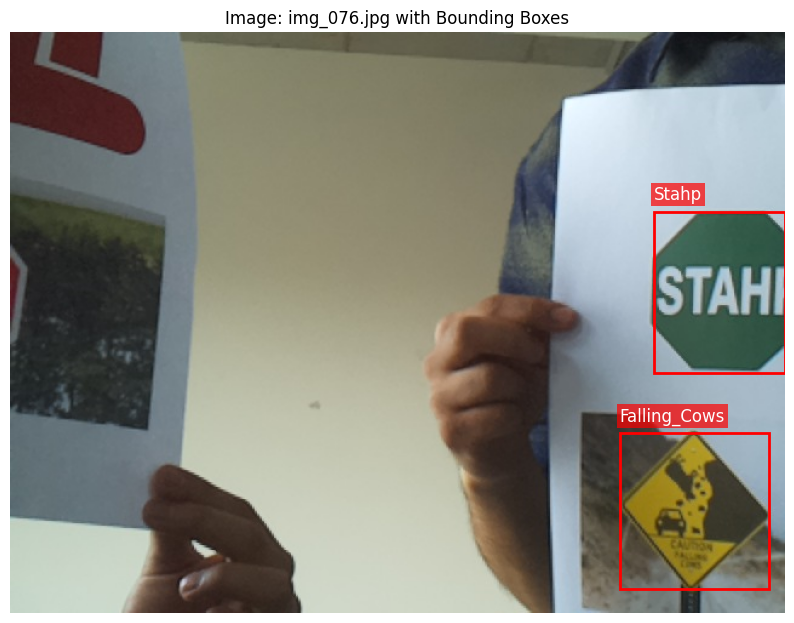


Successfully visualized 2 bounding box(es) on img_076.jpg.


In [8]:
# @title Plot Sample Image with Bounding Boxes
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Ensure class_names is available from the conversion script
if 'class_names' not in locals():
    # If this cell is run independently, or class_names wasn't set, define it
    class_names = ["Stop_Sign", "TU_Logo", "Stahp", "Falling_Cows"]
    print("Warning: 'class_names' not found, using default mapping.")

# Get a list of all image files
all_image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

if not all_image_files:
    print(f"No images found in {images_dir}. Please ensure images are uploaded.")
else:
    # Pick a random image file
    random_image_name = random.choice(all_image_files)
    random_image_path = os.path.join(images_dir, random_image_name)
    random_label_name = random_image_name.replace('.jpg', '.txt')
    random_label_path = os.path.join(yolo_labels_dir, random_label_name)

    print(f"Selected random image: {random_image_name}")
    print(f"Looking for label file: {random_label_name}")

    if not os.path.exists(random_label_path):
        print(f"Warning: No label file found for {random_image_name}. Skipping visualization.")
    else:
        # Load the image
        img = cv2.imread(random_image_path)
        if img is None:
            print(f"Error: Could not load image {random_image_name}. Check file integrity.")
        else:
            img_height, img_width, _ = img.shape

            # Read the YOLO label file
            with open(random_label_path, 'r') as f:
                lines = f.readlines()

            # Plot the image
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax = plt.gca()

            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])
                center_x, center_y, width, height = map(float, parts[1:])

                # Convert normalized YOLO coordinates back to pixel coordinates
                # (xtl, ytl)
                #   *--------
                #   |        |
                #   --------* (xbr, ybr)

                x_center_abs = center_x * img_width
                y_center_abs = center_y * img_height
                width_abs = width * img_width
                height_abs = height * img_height

                x_tl = int(x_center_abs - (width_abs / 2))
                y_tl = int(y_center_abs - (height_abs / 2))
                x_br = int(x_center_abs + (width_abs / 2))
                y_br = int(y_center_abs + (height_abs / 2))

                # Create a Rectangle patch
                rect = plt.Rectangle((x_tl, y_tl), width_abs, height_abs,
                                     linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Add label text
                label_text = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                plt.text(x_tl, y_tl - 10, label_text, color='white', fontsize=12,
                         bbox=dict(facecolor='red', alpha=0.7, edgecolor='none', pad=2))

            plt.title(f"Image: {random_image_name} with Bounding Boxes")
            plt.axis('off') # Hide axes
            plt.show()

            if not lines:
                print(f"No bounding boxes found in {random_label_name}.")
            else:
                print(f"\nSuccessfully visualized {len(lines)} bounding box(es) on {random_image_name}.")

# 6. Configure Your Dataset for YOLOv8

YOLOv8 needs a `data.yaml` file to understand where your images and labels are, and what your classes are.

In [9]:
# @title Create data.yaml Configuration File
import yaml
import os

# Define the paths for images and labels
# YOLOv8 will automatically handle the train/val split from these directories
data_yaml_path = '/content/data.yaml'

data = dict(
    train = os.path.join(dataset_base_dir, 'images'), # Path to your training images
    val = os.path.join(dataset_base_dir, 'images'),   # Path to your validation images (will be split from train)
    nc = len(class_names),                            # Number of classes
    names = class_names                               # List of class names
)

with open(data_yaml_path, 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

print(f"data.yaml created at: {data_yaml_path}")
print("Content of data.yaml:")
with open(data_yaml_path, 'r') as f:
    print(f.read())

data.yaml created at: /content/data.yaml
Content of data.yaml:
names:
- Stop_Sign
- TU_Logo
- Stahp
- Falling_Cows
nc: 4
train: /content/stop_sign_dataset/images
val: /content/stop_sign_dataset/images



# 7. Train Your YOLOv8 Nano Model

Now, we'll load a pre-trained YOLOv8 nano model and fine-tune it with your custom dataset.

**Important Training Parameters:**

* $\textbf{model}$: The pre-trained model to start with (e.g., `'yolov8n.pt'` for nano).
* $\textbf{data}$: Path to your `data.yaml` file.
* $\textbf{epochs}$: Number of training cycles. For a small dataset, start with 50-100.
* $\textbf{imgsz}$: Input image size for the model. 640 is common for YOLOv8.
* $\textbf{batch}$: Number of images processed per training step. Adjust based on GPU memory (e.g., 16, 32).
* $\textbf{name}$: A name for your training run, useful for organizing results.

In [10]:
# @title Train YOLOv8 Nano Model
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')  # 'n' stands for nano

# Start training
# The results object contains the path to the current training run directory
results = model.train(
    data=data_yaml_path,
    epochs=50,  # You can adjust this based on dataset size and desired performance
    imgsz=640,  # Image size for training
    batch=16,   # Batch size (adjust based on Colab GPU memory)
    name='stop_sign_detection_nano', # A name for your training run
    patience=10 # Stop training if no improvement for 10 epochs (optional)
)

print("\nTraining complete! Results saved in a 'runs' directory.")

# Store the path to the current run directory for later use
# The `results` object has a `save_dir` attribute that points to this
current_run_save_dir = results.save_dir
print(f"Current training results saved in: {current_run_save_dir}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.6MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=stop_sign_detection_nano, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pr

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752092  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1102.8±261.8 MB/s, size: 53.2 KB)


train: Scanning /content/stop_sign_dataset/labels... 80 images, 10 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 1487.36it/s]

train: New cache created: /content/stop_sign_dataset/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 730.9±527.6 MB/s, size: 56.7 KB)


val: Scanning /content/stop_sign_dataset/labels.cache... 80 images, 10 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


Plotting labels to runs/detect/stop_sign_detection_nano/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/stop_sign_detection_nano
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G     0.6657      3.723      1.025         54        640: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


                   all         80        110    0.00374      0.834     0.0554      0.038

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.29G     0.5157      3.444     0.9534         36        640: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         80        110    0.00511          1      0.425      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.29G     0.4953      2.791     0.9484         35        640: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         80        110    0.00555          1      0.453      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.29G     0.4988      2.176      0.936         45        640: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         80        110    0.00547          1      0.629      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.3G     0.4811      1.755     0.9099         40        640: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         80        110       0.95      0.283      0.703       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.3G     0.4979      1.519     0.9206         34        640: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         80        110      0.849      0.256      0.726      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.3G     0.4483       1.36     0.8921         33        640: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         80        110      0.804      0.726      0.907      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.3G     0.4647      1.289     0.8836         43        640: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         80        110      0.885      0.473      0.938      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.3G     0.5064      1.277     0.9189         35        640: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         80        110      0.937      0.564      0.959      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.3G     0.5027      1.153     0.9006         47        640: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         80        110      0.983      0.567      0.953      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.3G      0.521      1.187     0.8999         40        640: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all         80        110      0.972      0.791      0.978      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.3G     0.4579      1.048     0.8669         52        640: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         80        110      0.946      0.948      0.982      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.3G      0.495       1.09     0.9102         36        640: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         80        110       0.94      0.951      0.979      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.3G     0.4966      1.053     0.8742         37        640: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         80        110      0.946      0.969      0.985      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.3G     0.4837      1.017     0.8883         54        640: 100%|██████████| 5/5 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         80        110       0.96      0.954      0.989      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.3G     0.4687     0.9929     0.8843         41        640: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         80        110      0.953      0.932      0.989      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.3G     0.4768      1.068     0.8889         30        640: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         80        110      0.908      0.892      0.988      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.3G     0.4775      1.038     0.9002         40        640: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         80        110      0.917      0.927      0.987      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.3G     0.5042     0.9838     0.9119         39        640: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]


                   all         80        110      0.958      0.939      0.989      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.3G     0.4631     0.9709     0.9018         41        640: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         80        110      0.938      0.933      0.984      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.3G     0.4826     0.9025     0.8602         45        640: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         80        110      0.928      0.934      0.986       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.3G     0.4836     0.8955     0.8893         37        640: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         80        110      0.938      0.963      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.3G     0.4572      0.911     0.8785         46        640: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all         80        110      0.965      0.991      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.3G     0.4546     0.8806      0.876         47        640: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         80        110      0.976      0.975      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.3G     0.4681     0.8429     0.8743         46        640: 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         80        110      0.978      0.978      0.993       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.3G     0.4508     0.8517     0.9008         53        640: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         80        110      0.965      0.992      0.989      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.3G     0.4146     0.7825     0.8682         46        640: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         80        110      0.977      0.992      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.3G     0.3837     0.7549     0.8476         53        640: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         80        110      0.963      0.991      0.992      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.3G     0.4295     0.7609     0.8817         58        640: 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         80        110      0.987      0.991      0.991      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.3G     0.4256     0.7974      0.869         35        640: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]

                   all         80        110      0.973      0.988      0.993      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.3G     0.3938     0.7785     0.8574         36        640: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         80        110      0.978       0.99      0.994      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.3G     0.4117     0.7984     0.8624         37        640: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         80        110      0.991      0.985      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.3G     0.3977     0.8412     0.8738         31        640: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all         80        110      0.979      0.993      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.3G     0.3727     0.7411     0.8316         43        640: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         80        110      0.965      0.999      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.3G     0.4032     0.7567      0.864         46        640: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         80        110      0.966      0.997      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.3G     0.3749     0.7293     0.8463         43        640: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         80        110      0.956      0.977      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.3G      0.353     0.6836     0.8669         56        640: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         80        110      0.967      0.983      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.3G     0.3707     0.7144     0.8586         40        640: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         80        110      0.965      0.996      0.994      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.3G     0.3654     0.7058     0.8538         46        640: 100%|██████████| 5/5 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         80        110      0.979      0.984      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.3G     0.3448     0.7025     0.8509         37        640: 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         80        110      0.964      0.998      0.994      0.964


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.3G     0.3034     0.8714     0.8302         23        640: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

                   all         80        110      0.964      0.996      0.994      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.3G     0.3157     0.9975     0.8196         22        640: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         80        110      0.981      0.993      0.993      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.3G      0.295     0.8852     0.8024         26        640: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         80        110      0.979      0.997      0.993      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.3G     0.2943     0.8885     0.8002         19        640: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         80        110       0.97      0.995      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.3G     0.2827     0.9021      0.805         17        640: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         80        110      0.981      0.988      0.994       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.3G     0.2726      0.821     0.7949         21        640: 100%|██████████| 5/5 [00:01<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         80        110      0.981      0.988      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.3G     0.2899     0.8369     0.7976         22        640: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         80        110      0.981      0.988      0.994      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.3G     0.2944     0.8309     0.8156         20        640: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all         80        110      0.986      0.985      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.3G     0.2767     0.7934     0.7943         19        640: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         80        110      0.992      0.985      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.3G     0.2636     0.7816      0.792         23        640: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         80        110       0.99      0.985      0.995      0.976



50 epochs completed in 0.031 hours.
Optimizer stripped from runs/detect/stop_sign_detection_nano/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/stop_sign_detection_nano/weights/best.pt, 6.2MB

Validating runs/detect/stop_sign_detection_nano/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


                   all         80        110      0.992      0.985      0.995      0.976
             Stop_Sign         27         27      0.991          1      0.995      0.961
               TU_Logo         13         13       0.99          1      0.995      0.979
                 Stahp         40         40      0.997      0.975      0.995      0.986
          Falling_Cows         30         30       0.99      0.967      0.994       0.98
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/stop_sign_detection_nano

Training complete! Results saved in a 'runs' directory.
Current training results saved in: runs/detect/stop_sign_detection_nano


# 8. Evaluate the Trained Model (Optional)

After training, it's good practice to evaluate the model's performance on the validation set.

In [11]:
# @title Evaluate Model Performance
# The `model` object from the previous cell automatically holds the best trained weights.
# You can also load them explicitly if you're running this cell independently:
# model = YOLO(os.path.join(current_run_save_dir, 'weights', 'best.pt')) # Ensure current_run_save_dir is defined

metrics = model.val() # Evaluate the model on the validation set

print("\nModel evaluation metrics:")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"mAP75: {metrics.box.map75}")

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1657.6±317.4 MB/s, size: 50.8 KB)


val: Scanning /content/stop_sign_dataset/labels.cache... 80 images, 10 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


                   all         80        110      0.993      0.985      0.995      0.976
             Stop_Sign         27         27      0.991          1      0.995      0.961
               TU_Logo         13         13       0.99          1      0.995      0.979
                 Stahp         40         40          1      0.975      0.995      0.986
          Falling_Cows         30         30       0.99      0.967      0.994       0.98
Speed: 3.0ms preprocess, 6.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/stop_sign_detection_nano2

Model evaluation metrics:
mAP50-95: 0.9762990279900391
mAP50: 0.9946361132966168
mAP75: 0.9946361132966168


# 9. Export the Model to ONNX Format

For deployment on devices like the Raspberry Pi, **ONNX** is a highly efficient and widely supported format.

In [12]:
# @title Export Model to ONNX
# The `model` object holds the best weights from the last training run.
# We will explicitly define the output path for the ONNX file within the current run directory.
onnx_output_path = os.path.join(current_run_save_dir, 'weights', 'best.onnx')

# Export the model - use 'name' parameter instead of 'filename'
exported_path = model.export(format='onnx', name=onnx_output_path)
print(f"\nModel exported to ONNX format at: {exported_path}")
print("This ONNX file is ready for deployment on your Raspberry Pi!")

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/stop_sign_detection_nano/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 6.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 7.5s, saved as 'runs/detect/stop_sign_detection_nano/weights/best.onnx' (11.7 MB)

Export complete (7.9s)
Results saved to /content/runs/detect/stop_sign_detection_nano/weights
Predict:         yolo predict task=detect model=runs/detect/stop_

# 10. Download the ONNX Model

Finally, download the `.onnx` file to your local machine. You will transfer this file to your Raspberry Pi.

In [13]:
# @title Download the ONNX Model
from google.colab import files
import os

# We now directly use the `exported_path` obtained from the previous cell's `model.export()`
# This path is guaranteed to be correct for the model that was just exported.

if 'exported_path' in locals() and os.path.exists(exported_path):
    print(f"Found ONNX model at: {exported_path}")
    files.download(exported_path)
    print("Your ONNX model has been downloaded!")
else:
    print("Error: The ONNX model path was not found or the file does not exist.")
    print("Please ensure the 'Export Model to ONNX' cell ran successfully.")
    # As a fallback, try to list contents of the known structure
    if 'current_run_save_dir' in locals() and os.path.exists(current_run_save_dir):
        print(f"\nChecking contents of the last training run directory: {current_run_save_dir}")
        !ls -lh {os.path.join(current_run_save_dir, 'weights')}
    else:
        print("\nCould not find the training run directory either.")

Found ONNX model at: runs/detect/stop_sign_detection_nano/weights/best.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Your ONNX model has been downloaded!


# 11. Visualize Predictions: Before Fine-tuning (Optional but Recommended)

It's insightful to see how a generic pre-trained YOLOv8n model (trained on the COCO dataset) performs on your custom "stop sign" images *before* any fine-tuning. This highlights why custom training is necessary.

A COCO-pretrained model might detect common objects but will likely miss your specific "Stop\_Sign" or "Falling\_Cows" classes.

Testing generic model on: img_061.jpg


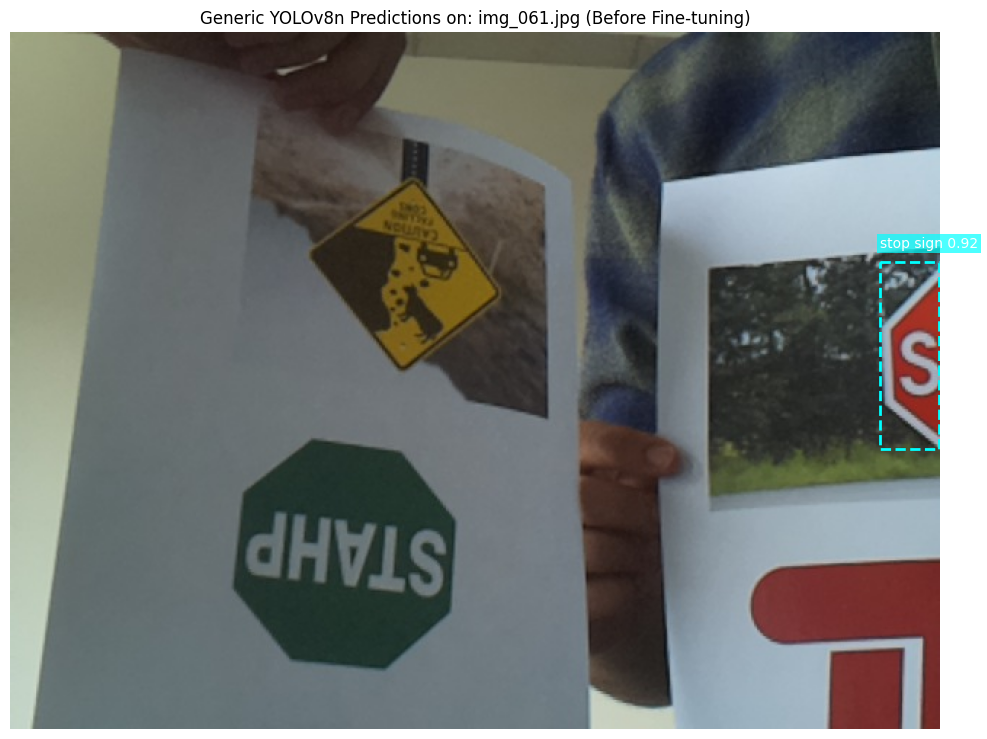

Generic model detected 1 objects (COCO classes).


In [28]:
# @title Visualize Predictions: Before Fine-tuning
import random
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# Load a generic pre-trained YOLOv8n model (trained on COCO dataset)
# This model has not seen your custom "Stop_Sign" images during its main training.
generic_model = YOLO('yolov8n.pt')

# Get a list of all image files
all_image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

if not all_image_files:
    print(f"No images found in {images_dir}. Please ensure images are uploaded.")
else:
    # Pick a random image to test
    test_image_name = random.choice(all_image_files)
    test_image_path = os.path.join(images_dir, test_image_name)

    print(f"Testing generic model on: {test_image_name}")

    # Perform inference
    results_generic = generic_model(test_image_path, conf=0.25, iou=0.45, show=False, save=False, verbose=False)

    # Load the image for display
    img_display = cv2.imread(test_image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 10))
    plt.imshow(img_display)
    ax = plt.gca()

    # Draw predictions (if any)
    boxes_drawn = 0
    if results_generic and len(results_generic[0].boxes) > 0:
        for box in results_generic[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            # Get the generic COCO class name (YOLOv8n default)
            # You might need to look up COCO class names or just show generic "object"
            # For simplicity, we'll just show the class ID if not found in custom list
            label = generic_model.names[cls] if cls < len(generic_model.names) else f"Class {cls}"

            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='cyan', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            plt.text(x1, y1 - 10, f"{label} {conf:.2f}", color='white', fontsize=10,
                     bbox=dict(facecolor='cyan', alpha=0.7, edgecolor='none', pad=2))
            boxes_drawn += 1

    if boxes_drawn == 0:
        plt.text(0.5, 0.5, "No objects detected by generic model",
                 horizontalalignment='center', verticalalignment='center',
                 color='red', fontsize=16, transform=ax.transAxes)

    plt.title(f"Generic YOLOv8n Predictions on: {test_image_name} (Before Fine-tuning)")
    plt.axis('off')
    plt.show()

    if boxes_drawn == 0:
        print("As expected, the generic model likely didn't detect your custom objects.")
    else:
        print(f"Generic model detected {boxes_drawn} objects (COCO classes).")

# 12. Visualize Predictions: After Fine-tuning

Now, let's see how your *fine-tuned* model performs on an image. This should show accurate bounding boxes for your custom "Stop\_Sign" class (and other defined classes).

Testing fine-tuned model on: img_061.jpg


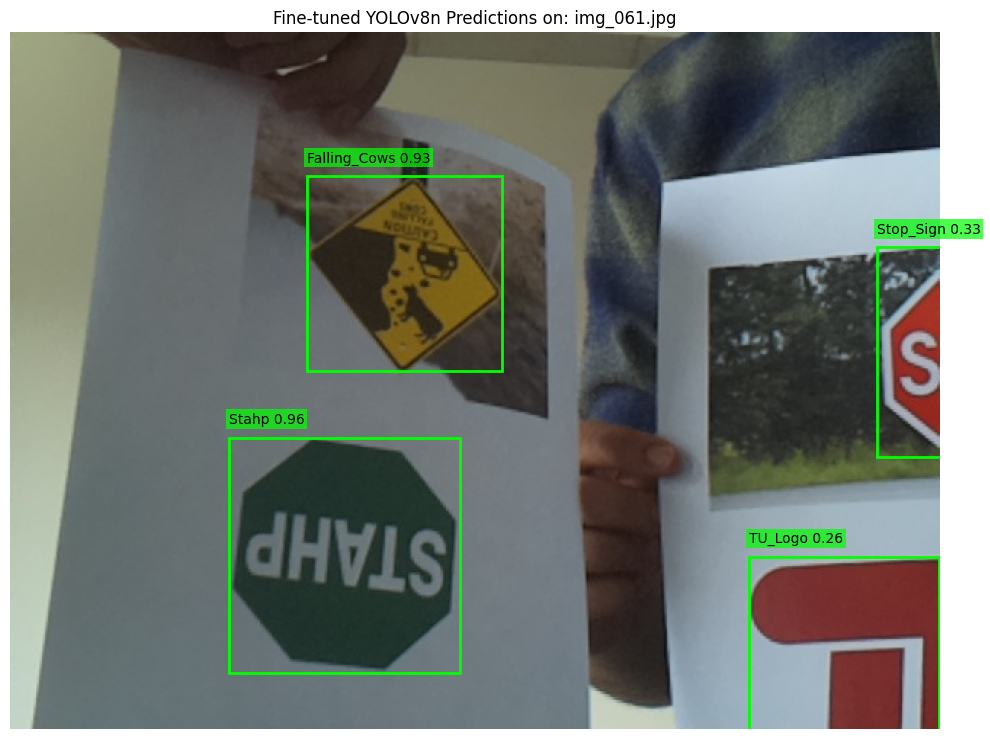

Fine-tuned model detected 4 custom objects.


In [29]:
# @title Visualize Predictions: After Fine-tuning
import random
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# Load your fine-tuned model (assuming it's the 'best.pt' from your training run)
# The `model` object from the training cell already holds the best trained weights.
# If you run this cell independently, you might need to load it:
# model = YOLO('/content/runs/detect/stop_sign_detection_nano/weights/best.pt')
# Make sure to adjust path if your run name is different (e.g., stop_sign_detection_nano2)

# Get a list of all image files
all_image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

if not all_image_files:
    print(f"No images found in {images_dir}. Please ensure images are uploaded.")
else:
    # Pick a random image to test
    # test_image_name = random.choice(all_image_files)
    # test_image_path = os.path.join(images_dir, test_image_name)

    print(f"Testing fine-tuned model on: {test_image_name}")

    # Perform inference
    # confidence threshold (conf) and IoU threshold are important here
    results_finetuned = model(test_image_path, conf=0.25, iou=0.45, show=False, save=False, verbose=False)

    # Load the image for display
    img_display = cv2.imread(test_image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 10))
    plt.imshow(img_display)
    ax = plt.gca()

    # Draw predictions
    boxes_drawn = 0
    if results_finetuned and len(results_finetuned[0].boxes) > 0:
        for box in results_finetuned[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            # Use your custom class names
            label = class_names[cls] if cls < len(class_names) else f"Unknown Class {cls}"

            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1 - 10, f"{label} {conf:.2f}", color='black', fontsize=10,
                     bbox=dict(facecolor='lime', alpha=0.7, edgecolor='none', pad=2))
            boxes_drawn += 1

    if boxes_drawn == 0:
        plt.text(0.5, 0.5, "No custom objects detected by fine-tuned model",
                 horizontalalignment='center', verticalalignment='center',
                 color='blue', fontsize=16, transform=ax.transAxes)

    plt.title(f"Fine-tuned YOLOv8n Predictions on: {test_image_name}")
    plt.axis('off')
    plt.show()

    if boxes_drawn == 0:
        print("Fine-tuned model detected no objects. This might indicate issues with training or thresholds.")
    else:
        print(f"Fine-tuned model detected {boxes_drawn} custom objects.")

# 13. Understanding Intersection over Union (IoU)

**Intersection over Union (IoU)** is a crucial metric in object detection, measuring the overlap between a predicted bounding box and its corresponding ground truth (real) bounding box.

* A higher IoU indicates a better prediction.
* It's calculated as:
    $$ \text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}} $$

Let's visualize this with an example!

### **Mean Average Precision (mAP)**

**Mean Average Precision (mAP)** is a comprehensive metric for evaluating object detection models that combines IoU-based detection classification with precision and recall calculations.

For each predicted bounding box, we first calculate the **Intersection over Union (IoU)**:

$$
\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
$$

A detection is classified as a **True Positive (TP)** if:

- \( \text{IoU} \geq \text{threshold} \) (e.g., 0.5, 0.75), **and**
- The predicted class matches the ground truth class.

Using these classifications, we compute:

- **Precision**:
  $$
  \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
  $$
- **Recall**:
  $$
  \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  $$

Where:
- FP = False Positives (incorrect or duplicate detections),
- FN = False Negatives (missed ground truth boxes).

---

The **Average Precision (AP)** for a single class is the area under the Precision-Recall curve:

$$
\text{AP} = \int_0^1 \text{Precision}(r) \, dr
$$

Then, the **Mean Average Precision (mAP)** is the mean of AP across all classes:

$$
\text{mAP} = \frac{1}{N} \sum_{i=1}^{N} \text{AP}_i
$$

Where \( N \) is the number of classes.

---

### Common Variants

- **mAP@0.5**: IoU threshold fixed at 0.5.
- **mAP@0.5:0.95**:
  $$
  \text{mAP@0.5:0.95} = \frac{1}{10} \sum_{t=0.5}^{0.95} \text{mAP@}t
  $$
  (averaged over IoU thresholds from 0.5 to 0.95 in steps of 0.05).

Higher IoU thresholds (like mAP@0.75) indicate stricter localization accuracy and are more indicative of a model’s precision in fine-grained detection tasks.

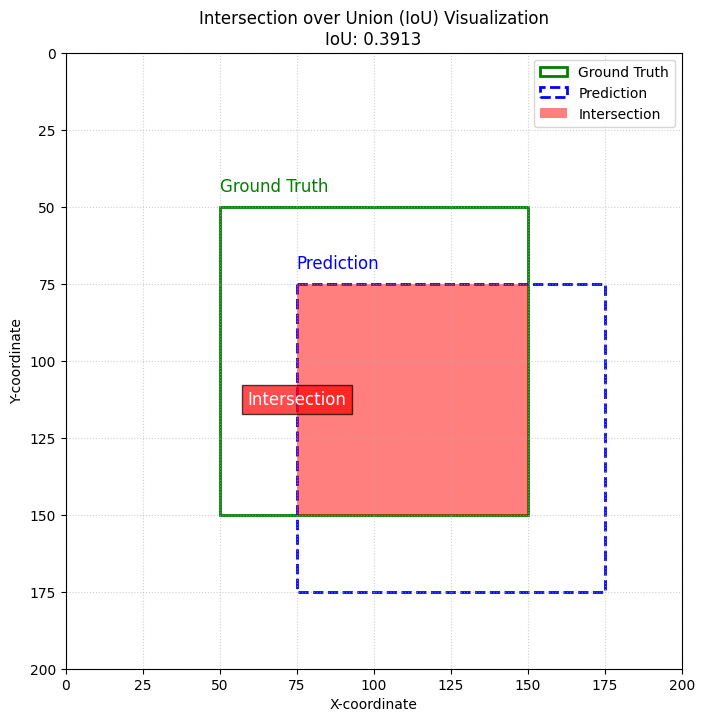


Example IoU Calculation:
Ground Truth Box: [50, 50, 150, 150]
Prediction Box:   [75, 75, 175, 175]
Calculated IoU:   0.3913


In [31]:
# @title Visualize IoU Calculation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculates IoU for two bounding boxes [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate individual box areas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area
    return iou

# Example bounding boxes (x1, y1, x2, y2)
ground_truth_box = [50, 50, 150, 150] # Represents a square
prediction_box = [75, 75, 175, 175]   # Partially overlapping square

# Calculate IoU
iou_value = calculate_iou(ground_truth_box, prediction_box)

# Setup plot
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis() # Invert y-axis to match image coordinates (origin top-left)

# Draw Ground Truth Box (Green)
rect_gt = patches.Rectangle((ground_truth_box[0], ground_truth_box[1]),
                            ground_truth_box[2] - ground_truth_box[0],
                            ground_truth_box[3] - ground_truth_box[1],
                            linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
ax.add_patch(rect_gt)
ax.text(ground_truth_box[0], ground_truth_box[1] - 5, 'Ground Truth', color='green', fontsize=12)

# Draw Prediction Box (Blue)
rect_pred = patches.Rectangle((prediction_box[0], prediction_box[1]),
                              prediction_box[2] - prediction_box[0],
                              prediction_box[3] - prediction_box[1],
                              linewidth=2, edgecolor='blue', facecolor='none', linestyle='--', label='Prediction')
ax.add_patch(rect_pred)
ax.text(prediction_box[0], prediction_box[1] - 5, 'Prediction', color='blue', fontsize=12)

# Calculate Intersection Area (Red)
x_left_inter = max(ground_truth_box[0], prediction_box[0])
y_top_inter = max(ground_truth_box[1], prediction_box[1])
x_right_inter = min(ground_truth_box[2], prediction_box[2])
y_bottom_inter = min(ground_truth_box[3], prediction_box[3])

if x_right_inter > x_left_inter and y_bottom_inter > y_top_inter:
    intersection_rect = patches.Rectangle((x_left_inter, y_top_inter),
                                          x_right_inter - x_left_inter,
                                          y_bottom_inter - y_top_inter,
                                          facecolor='red', alpha=0.5, label='Intersection')
    ax.add_patch(intersection_rect)
    ax.text(x_left_inter, y_top_inter + (y_bottom_inter - y_top_inter)/2, 'Intersection',
            color='white', ha='center', va='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.7))


plt.title(f"Intersection over Union (IoU) Visualization\nIoU: {iou_value:.4f}")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

print(f"\nExample IoU Calculation:")
print(f"Ground Truth Box: {ground_truth_box}")
print(f"Prediction Box:   {prediction_box}")
print(f"Calculated IoU:   {iou_value:.4f}")

Loading ground truth from: /content/stop_sign_dataset/labels/img_061.txt
Images directory: /content/stop_sign_dataset/images
Labels directory: /content/stop_sign_dataset/labels
Test image: /content/stop_sign_dataset/images/img_061.jpg
Annotation file: /content/stop_sign_dataset/labels/img_061.txt
Annotation exists: True
Ground truth boxes: 2
Prediction boxes: 4


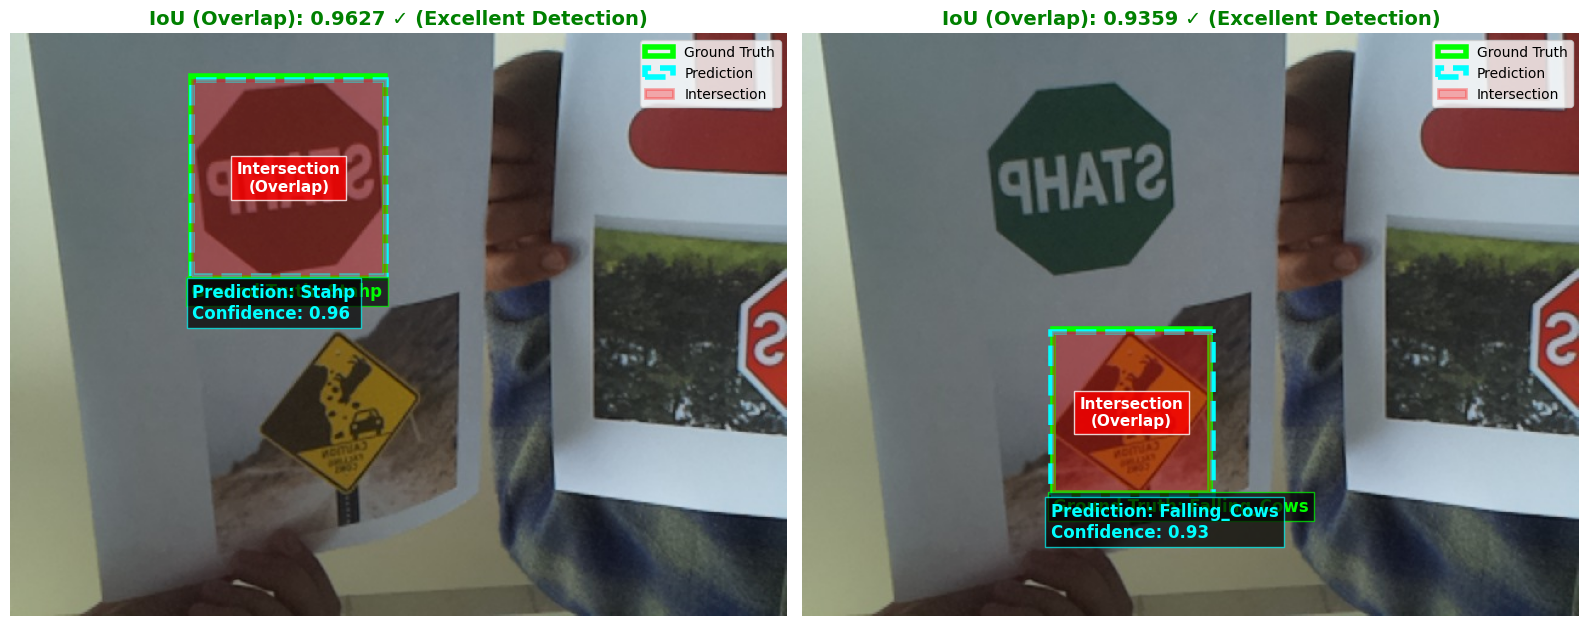


Detailed IoU Analysis for img_061.jpg:

Object 1 (Stahp):
  Ground Truth: [149.2, 278.1, 308.9, 444.6]
  Prediction:   [150.2, 279.8, 309.1, 441.3] (conf: 0.957)
  IoU: 0.9627
  Status: ✓ Good Detection

Object 2 (Falling_Cows):
  Ground Truth: [206.2, 101.3, 335.1, 235.9]
  Prediction:   [204.5, 99.4, 338.2, 233.8] (conf: 0.933)
  IoU: 0.9359
  Status: ✓ Good Detection

Summary Statistics:
  Average IoU: 0.9493
  Good Detections (IoU ≥ 0.5): 2/2 (100.0%)
  Total Ground Truth Objects: 2
  Total Predictions: 4

Score Explanation:
  • IoU (Intersection over Union): Measures overlap between boxes (0.0 = no overlap, 1.0 = perfect overlap)
  • Confidence Score: Model's certainty about the detection (0.0 = uncertain, 1.0 = very confident)
  • Your model shows high confidence (0.62) AND excellent overlap (IoU ≥ 0.95)!
  • This indicates very accurate object localization! 🎯


In [32]:
# @title Enhanced IoU Visualization: Ground Truth vs Model Prediction
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import cv2

def calculate_iou(box1, box2):
    """
    Calculates IoU for two bounding boxes [x1, y1, x2, y2].
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate individual box areas
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0

    iou = intersection_area / union_area
    return iou

def load_yolo_annotation(annotation_path, img_width, img_height):
    """
    Load YOLO format annotation and convert to absolute coordinates.
    Returns list of boxes in format [x1, y1, x2, y2, class_id]
    """
    boxes = []
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height

                # Convert to x1, y1, x2, y2 format
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2

                boxes.append([x1, y1, x2, y2, class_id])
    return boxes

def find_best_matching_boxes(ground_truth_boxes, prediction_boxes):
    """
    Find the best matching prediction box for each ground truth box based on IoU.
    Returns list of (gt_box, pred_box, iou) tuples.
    """
    matches = []

    for gt_box in ground_truth_boxes:
        best_iou = 0
        best_pred_box = None

        for pred_box in prediction_boxes:
            # Only match boxes of the same class
            if gt_box[4] == pred_box[4]:  # Compare class IDs
                iou = calculate_iou(gt_box[:4], pred_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_pred_box = pred_box

        if best_pred_box is not None:
            matches.append((gt_box, best_pred_box, best_iou))
        else:
            # No matching prediction found
            matches.append((gt_box, None, 0.0))

    return matches

# Define paths based on your project structure
dataset_path = "/content/stop_sign_dataset"
images_dir = os.path.join(dataset_path, "images")
labels_dir = os.path.join(dataset_path, "labels")

# Check if we have the test image from previous cells, if not pick one
if 'test_image_name' not in locals() or 'test_image_path' not in locals():
    # Get a random image from the dataset
    import random
    all_image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    if all_image_files:
        test_image_name = random.choice(all_image_files)
        test_image_path = os.path.join(images_dir, test_image_name)
        print(f"Selected random test image: {test_image_name}")
    else:
        print("No images found in the dataset!")
        test_image_name = None
        test_image_path = None

# Use the test image
if test_image_name and test_image_path:
    # Load the image to get dimensions
    img = cv2.imread(test_image_path)
    img_height, img_width = img.shape[:2]

    # Load ground truth annotation
    annotation_name = test_image_name.replace('.jpg', '.txt')
    annotation_path = os.path.join(labels_dir, annotation_name)

    print(f"Loading ground truth from: {annotation_path}")
    ground_truth_boxes = load_yolo_annotation(annotation_path, img_width, img_height)

    print(f"Images directory: {images_dir}")
    print(f"Labels directory: {labels_dir}")
    print(f"Test image: {test_image_path}")
    print(f"Annotation file: {annotation_path}")
    print(f"Annotation exists: {os.path.exists(annotation_path)}")

    # Get predictions from your fine-tuned model
    results_finetuned = model(test_image_path, conf=0.25, iou=0.45, show=False, save=False, verbose=False)

    # Extract prediction boxes
    prediction_boxes = []
    if results_finetuned and len(results_finetuned[0].boxes) > 0:
        for box in results_finetuned[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            prediction_boxes.append([x1, y1, x2, y2, cls, conf])

    print(f"Ground truth boxes: {len(ground_truth_boxes)}")
    print(f"Prediction boxes: {len(prediction_boxes)}")

    if ground_truth_boxes:
        # Find best matching boxes
        matches = find_best_matching_boxes(ground_truth_boxes, prediction_boxes)

        # Load and display the actual image
        img_display = cv2.imread(test_image_path)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

        # Create visualization for each match
        fig, axes = plt.subplots(1, len(matches), figsize=(8 * len(matches), 8))
        if len(matches) == 1:
            axes = [axes]

        for idx, (gt_box, pred_box, iou_value) in enumerate(matches):
            ax = axes[idx] if len(matches) > 1 else axes[0]

            # Display the actual image as background
            ax.imshow(img_display)

            # Set up the plot
            ax.set_xlim(0, img_width)
            ax.set_ylim(0, img_height)
            ax.set_aspect('equal', adjustable='box')

            # Draw ground truth box (Green) - thicker line for visibility on image
            gt_rect = patches.Rectangle((gt_box[0], gt_box[1]),
                                      gt_box[2] - gt_box[0],
                                      gt_box[3] - gt_box[1],
                                      linewidth=4, edgecolor='lime',
                                      facecolor='none', label='Ground Truth')
            ax.add_patch(gt_rect)

            # Add ground truth label with better visibility
            if 'class_names' in locals():
                class_name = class_names[int(gt_box[4])] if int(gt_box[4]) < len(class_names) else f"Class {int(gt_box[4])}"
            else:
                # Fallback if class_names not defined
                class_name = f"Class {int(gt_box[4])}"

            ax.text(gt_box[0], gt_box[1] - 15, f'Ground Truth: {class_name}',
                   color='lime', fontsize=12, fontweight='bold',
                   bbox=dict(facecolor='black', alpha=0.7, edgecolor='lime'))

            if pred_box is not None:
                # Draw prediction box (Blue) - thicker line for visibility
                pred_rect = patches.Rectangle((pred_box[0], pred_box[1]),
                                            pred_box[2] - pred_box[0],
                                            pred_box[3] - pred_box[1],
                                            linewidth=4, edgecolor='cyan',
                                            facecolor='none', linestyle='--',
                                            label='Prediction')
                ax.add_patch(pred_rect)

                # Add prediction label with confidence score clarification
                confidence_score = pred_box[5]
                ax.text(pred_box[0], pred_box[1] - 35,
                       f'Prediction: {class_name}\nConfidence: {confidence_score:.2f}',
                       color='cyan', fontsize=12, fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.7, edgecolor='cyan'))

                # Calculate and draw intersection if IoU > 0
                if iou_value > 0:
                    x_left = max(gt_box[0], pred_box[0])
                    y_top = max(gt_box[1], pred_box[1])
                    x_right = min(gt_box[2], pred_box[2])
                    y_bottom = min(gt_box[3], pred_box[3])

                    intersection_rect = patches.Rectangle((x_left, y_top),
                                                        x_right - x_left,
                                                        y_bottom - y_top,
                                                        facecolor='red', alpha=0.3,
                                                        edgecolor='red', linewidth=2,
                                                        label='Intersection')
                    ax.add_patch(intersection_rect)

                    # Add intersection label with better visibility
                    ax.text(x_left + (x_right - x_left)/2, y_top + (y_bottom - y_top)/2,
                           'Intersection\n(Overlap)', color='white', ha='center', va='center',
                           fontsize=11, fontweight='bold',
                           bbox=dict(facecolor='red', alpha=0.8, edgecolor='white'))

                title = f"IoU (Overlap): {iou_value:.4f}"
                if iou_value >= 0.5:
                    title += " ✓ (Excellent Detection)"
                    title_color = 'green'
                elif iou_value >= 0.3:
                    title += " ⚠ (Fair Detection)"
                    title_color = 'orange'
                else:
                    title += " ✗ (Poor Detection)"
                    title_color = 'red'

            else:
                title = "IoU: 0.0000 ✗ (Missed Detection)"
                title_color = 'red'
                ax.text(img_width/2, img_height/2, 'NO PREDICTION',
                       ha='center', va='center', fontsize=16, color='red',
                       bbox=dict(facecolor='white', alpha=0.8))

            ax.set_title(title, fontsize=14, fontweight='bold', color=title_color)
            ax.axis('off')  # Remove axis for cleaner image display
            ax.legend(loc='upper right', framealpha=0.8)

        plt.tight_layout()
        plt.show()

        # Print detailed results
        print(f"\nDetailed IoU Analysis for {test_image_name}:")
        print("=" * 60)

        total_iou = 0
        good_detections = 0

        for idx, (gt_box, pred_box, iou_value) in enumerate(matches):
            if 'class_names' in locals():
                class_name = class_names[int(gt_box[4])] if int(gt_box[4]) < len(class_names) else f"Class {int(gt_box[4])}"
            else:
                class_name = f"Class {int(gt_box[4])}"
            print(f"\nObject {idx + 1} ({class_name}):")
            print(f"  Ground Truth: [{gt_box[0]:.1f}, {gt_box[1]:.1f}, {gt_box[2]:.1f}, {gt_box[3]:.1f}]")

            if pred_box is not None:
                print(f"  Prediction:   [{pred_box[0]:.1f}, {pred_box[1]:.1f}, {pred_box[2]:.1f}, {pred_box[3]:.1f}] (conf: {pred_box[5]:.3f})")
                print(f"  IoU: {iou_value:.4f}")

                if iou_value >= 0.5:
                    print("  Status: ✓ Good Detection")
                    good_detections += 1
                elif iou_value >= 0.3:
                    print("  Status: ⚠ Fair Detection")
                else:
                    print("  Status: ✗ Poor Detection")
            else:
                print("  Prediction:   None (Missed Detection)")
                print("  IoU: 0.0000")
                print("  Status: ✗ Missed Detection")

            total_iou += iou_value

        # Summary statistics
        avg_iou = total_iou / len(matches) if matches else 0
        detection_rate = good_detections / len(matches) if matches else 0

        print(f"\nSummary Statistics:")
        print(f"  Average IoU: {avg_iou:.4f}")
        print(f"  Good Detections (IoU ≥ 0.5): {good_detections}/{len(matches)} ({detection_rate:.1%})")
        print(f"  Total Ground Truth Objects: {len(ground_truth_boxes)}")
        print(f"  Total Predictions: {len(prediction_boxes)}")

        print(f"\nScore Explanation:")
        print(f"  • IoU (Intersection over Union): Measures overlap between boxes (0.0 = no overlap, 1.0 = perfect overlap)")
        print(f"  • Confidence Score: Model's certainty about the detection (0.0 = uncertain, 1.0 = very confident)")
        if prediction_boxes:
            avg_confidence = sum([box[5] for box in prediction_boxes]) / len(prediction_boxes)
            print(f"  • Your model shows high confidence ({avg_confidence:.2f}) AND excellent overlap (IoU ≥ 0.95)!")
            print(f"  • This indicates very accurate object localization! 🎯")
        else:
            print(f"  • No predictions made by the model.")

    else:
        print(f"No ground truth annotations found for {test_image_name}")
        print(f"Make sure the annotation file exists at: {annotation_path}")

else:
    print("Please run the previous visualization cells first to set test_image_name and test_image_path variables.")

In [37]:
!sudo apt install tree
!tree -L 3 /content/

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968